Test d'un schéma approchant de manière particulaire la vitesse et de façon semi-lagrangienne la position.

In [1]:
using LinearAlgebra, QuadGK, Roots, FFTW
using VlasovSolvers
using Plots

import VlasovSolvers: advection!
import VlasovSolvers: samples, Particles, PIC_step!, compute_rho
using ProgressMeter

using LaTeXStrings

In [2]:
function solve_PIC!(nsteps, dt, particles, meshx; plotting=false::Bool)
    potential = []
    energy_elec_from_phi = []
    energy_pic = []
    energy_hamil_elec = []
    energy_hamil_cine = []
    energy_tot = []
    L = meshx.stop
    np = length(p.x)
    progression = ProgressMeter.Progress(nsteps,desc="Loop in time: ", showspeed=true)
    animation = @animate for istep = 1:nsteps # Loop over time
        if plotting
            plot(size=(500, 500), ylim=(0, .5),
                widen=false, st=:surface, camera=(-30, 30))
            histogram2d(copy(p.x), copy(p.v), bins=500, normalize=true,
                xlabel="position", ylabel="velocity")
            title!("Progression: $(round(Int64,100*progression.counter / progression.n))%")
        end

        e1, e2, e3 = PIC_step!(p, meshx, dt)
        push!(energy_hamil_elec, e1)
        push!(energy_pic, e2)
        push!(energy_elec_from_phi, e3)
        
        ProgressMeter.next!(progression)
    end when plotting
    return energy_hamil_elec, energy_pic, energy_elec_from_phi, animation
end

solve_PIC! (generic function with 1 method)

# INPUTS

## Landau damping

In [3]:
kx = 0.4
L = 2π / kx
ϵ = 0.001
μ = 0.0
β = 1.0
f(x,v) = (1 + ϵ * cos(kx*x)) * exp(-β * (v-μ)^2 / 2) / √(2π/β)
castest = "Landau damping\n(kx, ϵ, μ, β) = $((kx, ϵ, μ, β)))"

"Landau damping\n(kx, ϵ, μ, β) = (0.4, 0.001, 0.0, 1.0))"

## Two-Stream Instability

In [ ]:
kx = 0.2
L = 2π / kx
ϵ = 0.001
β₁ = 1
β₂ = 2
v0 = 2.4
μ₁ =  v0
μ₂ = -v0
@. f(x,v) = (1 + ϵ * cos(kx * x)) * (exp(-β₁*(v-μ₁)^2 / 2) + exp(-β₁*(v-μ₂)^2 / 2)) / (2*√(2π))
castest = "TSI\n(kx, β₁, β₂, μ₁, μ₂) = $((kx, β₁, β₂, μ₁, μ₂))"

## Bump-on-Tail

In [ ]:
kx = 0.3
L = 3*2π / kx
ϵ = 0.04
β₁ = 1
β₂ = 1 / (0.5^2)
μ₁ = 0
μ₂ = 4.5
nb = 0.2
np = 0.9
@. f(x,v) = (1 + ϵ * cos(kx*x)) * (np*exp(-β₁*(v-μ₁)^2 /2) + nb*exp(-β₂*(v-μ₂)^2 / 2)) / √(2π)
castest = "Bump on tail\n(kx, ϵ, β₁, β₂, μ₁, μ₂, nb, np) = $((kx, ϵ, β₁, β₂, μ₁, μ₂, nb, np))"

## Strong Landau Damping

In [ ]:
kx = 0.5
L = 2π / kx
ϵ = 0.5
β = 1.0
μ = 0.0
@. f(x,v) = (1 + ϵ * cos(kx*x)) * exp(-β * v^2 / 2) / √(2π/β)
castest = "Strong Landau damping\n(kx, ϵ, μ, β) = $((kx, ϵ, μ, β)))"

# Inputs indépendants du cas test

In [48]:
dev = CPU()

nstep = 5000
dt = 0.01

0.01

# PIC

In [ ]:
np = 5_000
nx = 32

In [ ]:
meshpic = OneDGrid(dev, nx, 0, L)

@time (x0, y0, wei) = samples(np, kx, ϵ, μ, β)
p = Particles(x0, y0, wei, np);

## Regular PIC :

In [ ]:
gr()
energy_hamil_elec, energy_pic, energy_elec_from_phi, animation = solve_PIC!(nstep, dt, p, meshpic, plotting=true);
if animation != nothing
    gif(animation, "full_pic.gif")
end

In [ ]:
t = range(0., stop=nstep*dt, length=nstep) |> collect;

plot(t, log.(sqrt.(energy_pic)), label="PIC", xlabel="time")
plot!(t, log.(sqrt.(max.(energy_hamil_elec, 10^-12))), label="Hamiltonian")
plot!(t, log.(sqrt.(energy_elec_from_phi)), label="Potential")
plot!(x-> -0.286x + 1, label="y = -0.286x + 1", 0, 20)
plot!(x->0.086671x - 3.8, label="y = 0.086671x - 3.8")
plot!(minorgrid=true, legend=:topright)

# Méthode via caractéristiques

In [40]:
nx = 64
nv = 63

63

In [41]:
meshx = OneDGrid(dev, nx, 0, L)
meshv = OneDGrid(dev, nv, -10, 10)
x0 = Array(meshx.points)
v0 = Array(meshv.points);

In [42]:
newX = repeat(x0, 1, nv);   # newX[i, j] is position at current time when starting from x0_i, v0_j
newV = repeat(v0', nx, 1);  # newV[i, j] is velocity at current time when starting from x0_i, v0_j

In [43]:
C = sum(cos.(x0 .* kx) .* f.(x0, v0')) .* meshx.step .* meshv.step
S = sum(sin.(x0 .* kx) .* f.(x0, v0')) .* meshx.step .* meshv.step

println(log(sqrt(sum((-C.*sin.(x0.*kx) + S.*cos.(kx.*x0)).^2 / π^2)*meshx.step)))
println(log.(sqrt((C^2 + S^2) / (kx*π))))

-4.9609542382460505
-4.9609542382460505


In [44]:
size(f.(newX, newV)), size(f.(x0, v0'))

((64, 63), (64, 63))

In [45]:
plotting = false

# ====== #

E_elec  = Array{Float64}(undef, nstep)
E_elec2 = Array{Float64}(undef, nstep)
E_tot   = Array{Float64}(undef, nstep)
dphidx  = similar(newX)
arr_C   = Array{Float64}(undef, nstep)
arr_S   = Array{Float64}(undef, nstep)

gr() # plotting backend

progression = ProgressMeter.Progress(nstep,desc="Loop in time: ", showspeed=true)


f0vals = f.(x0, v0')


if !plotting 
    plot()
end


newX .+= dt/2 .* newV

animation = @animate for istep=1:nstep
    C = sum(cos.(newX .* kx) .* f0vals) .* meshx.step .* meshv.step
    S = sum(sin.(newX .* kx) .* f0vals) .* meshx.step .* meshv.step
    arr_C[istep] = C
    arr_S[istep] = S

    dphidx   .= (-C.*sin.(newX .* kx) .+ S.*cos.(newX .* kx)) / π
    E_elec[istep] = sqrt((C^2 + S^2) / (kx*π))
    # E_elec[istep] = sqrt(sum((-C.*sin.(x0.*kx) + S.*cos.(kx.*x0)).^2 / π^2)*meshx.step)
    E_tot[istep] = sqrt(E_elec[istep]^2 + sum(newV.^2 .* f0vals) * meshx.step * meshv.step) / √2 
    newV    .-= dt .* dphidx
    newX    .+= dt .* newV

    for ix = eachindex(newX)
        if newX[ix] > L
            newX[ix] -= L
        elseif  newX[ix] < 0
            newX[ix] += L
        end
    end

    if plotting
        p1 = plot(x0, v0, f.(newX, newV)', size=(500, 500), st=:surface, camera=(0, 90), widen=false)
        p2 = histogram2d(vec(newX), vec(newV), bins=250, normalize=true, xlabel="position", ylabel="velocity", fillcolor=:roma)
        plot(p1, p2)
        title!("Progression: $(round(Int64,100*progression.counter / progression.n))%")
    end
    ProgressMeter.next!(progression)
end

Loop in time: 100%|███████████████████████| Time: 0:00:27 (27.46 ms/it)


Animation("/var/folders/1v/s8fdlw053q9c2r1q78pk38c000m_wq/T/jl_bJzSwY", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000991.png", "000992.png", "000993.png", "000994.png", "000995.png", "000996.png", "000997.png", "000998.png", "000999.png", "001000.png"])

In [46]:
if plotting
    gif(animation, "semilag_caracteristiques.gif")
end

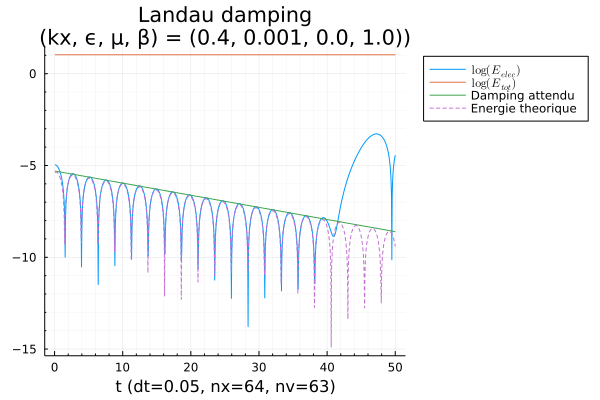

In [47]:
t = (1:nstep).*dt

# energies
# plot(t, E_elec.^2, label=L"E_{elec}^2", legend=:outertopright, minorgrid=true)
# plot!(t, E_tot, label=L"E_{tot}", scaley=:log10)

# log(Energies)
plot(t, log.(E_elec), label=L"\log(E_{elec})", legend=:outertopright, minorgrid=true)
# plot(t, E_elec.^2)
plot!(t, log.(E_tot), label=L"\log(E_{tot})")

# ============== #

# Landau damping (kx=0.5):
# plot!(x->-0.1533x - 6.8, label="Damping attendu")
# Landau damping (kx=0.4):
plot!(x->-0.0661x - 5.3, label="Damping attendu")
# E_th = 0.002.*0.42466.*abs.(cos.(1.285.*t .-0.33577)).*exp.(-0.0661.*t) # expression du bouquin, pas correcte
E_th = abs.(4*ϵ*0.424666*exp.(-0.0661 .* t) .* sqrt(π/kx) .* cos.(1.2850 .* t .- 0.3357725)) # issue des calculs du bouquin en calculant correctement √(∫sin(0.5x)^2dx)
plot!(t, log.(E_th),label="Energie theorique", ls=:dash)

# TSI (k,v0) = (0.2, 1.3):
# plot!(t, 0.001t .- 5.0, label=L"y=0.001t - 5.0")
# TSI (k,v0) = (0.2, 2.4):
# plot!(t, 0.2258t .- 8.1, label=L"y=0.2258t - 8.4")
# TSI (k,v0) = (0.2, 3):
# plot!(t, 0.2845t .- 7.9, label=L"y=0.2845t - 8.2")

# Strong Landau damping
# plot!(t, -0.285473t .- 0.4, label=L"y=-0.285473t .- 0.4")
# plot!(t, 0.086671t .- 4.5, label=L"y=0.086671t .- 4.5")

title!(castest)
xlabel!("t (dt=$(dt), nx=$(nx), nv=$(nv))")

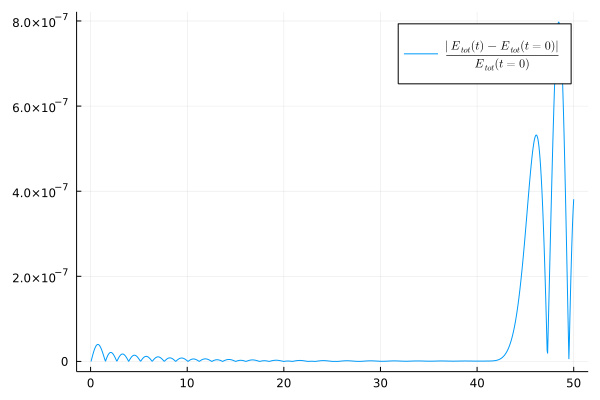

In [13]:
plot(t, abs.((E_tot .- E_tot[1])) ./ E_tot[1], label=L"\frac{|E_{tot}(t) - E_{tot}(t=0)|}{E_{tot}(t=0)}")

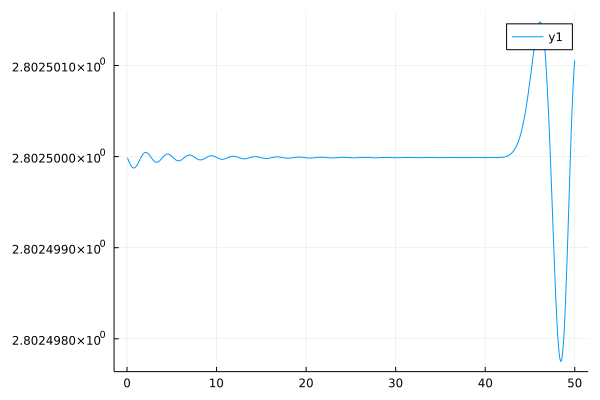

In [14]:
plot(t, E_tot)

In [25]:
log(E_th[1]) - log.(E_elec[1])

-2.1506988787914807

In [26]:
log.(L)

2.7541677982835004